# 5-Entrenamiento

El entrenamiento contemplará el uso de los algoritmos supervisados CO y FHMM provistos por NILMTK, usando la señal de potencia activa de los dispositivos. Para cada algoritmo se entrenarán varios modelos usando diferentes periodos de muestreo entre 1 segundo y 10 minutos. Esto permitirá posteriormente comparar los modelos

Primero  cargamos  las librerías necesarias y realizamos los ajustes correspondientes:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
warnings. filterwarnings("ignore")
plt.style.use('bmh')

from nilmtk import TimeFrame, MeterGroup, HDFDataStore, DataSet



#dataset de referencia 
ompm = DataSet('ualm2.h5')




elec=ompm.buildings[1].elec # Todos los medidores

print (elec)

labels = pd.DataFrame({'Instances': list(range(1,7)),
                       'Meters': ['Main', 'Fryer', 'LED Lamp',  'Incandescent lamp','Laptop Computer', 'Fan']})




Meters={}
for x in range(len(labels)): Meters[elec[x+1]]=labels['Meters'][x]

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='DSUAL', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])
  ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])
  ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])
  ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])
)


## Set de Entrenamiento

In [2]:
#Set para entrenamiento


#dataset de referencia DSUALM
train = DataSet('ualm2.h5')
train.set_window(start="2023-05-09 08:55:45", end="2023-05-09 10:44:38")

train_elec = train.buildings[1].elec

#Dispositivos para entrenamiento
train_Devices = train_elec.select(instance=[2,3,4,5,6])
train_Devices

MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])
  ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])
  ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])
  ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])
)

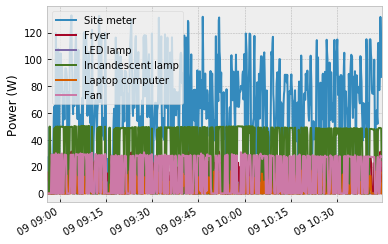

In [3]:
train_elec.plot()

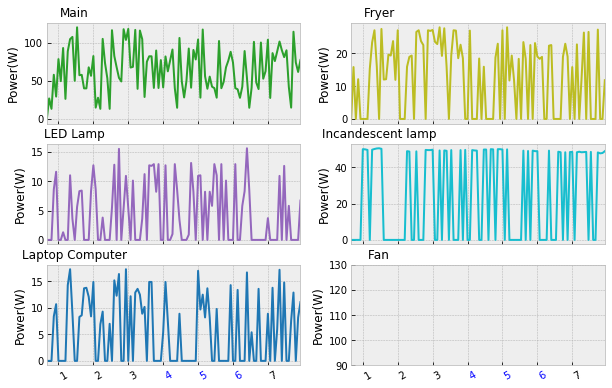

In [4]:
rcParams['figure.figsize'] = (10, 7)

fig, ((ax1, ax2),(ax3, ax4),(ax5, ax6)) = plt.subplots(3, 2, sharex=True,
                                                       gridspec_kw={'hspace': 0.2, 'wspace': 0.2})
#colores
colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan']
m=1
for ax in fig.get_axes(): 
    next(train_elec[m].load(ac_type='active', sample_period=60,
                            resample_kwargs={'how':'first'})).plot(ax=ax, legend=False, color=colors[m-5])   
    ax.set_ylabel('Power(W)')
    ax1.set_ylim(auto=True)
    ax.minorticks_off()
    ax.set_xticklabels(labels=['1','2','3','4','5','6','7','8'], ha ='left')    
    ax.set_title(labels['Meters'][m-1], fontsize=12).set_position([.11, 1])
    c=['k','k','k','b','b','b','k','k']
    [t.set_color(i) for (i,t) in zip(c, ax.xaxis.get_ticklabels())]
    m=m+1

ax6.set_ylim(90,130)   
plt.savefig('./data/images/4.1_Plot_train.svg', bbox_inches='tight', transparent=True)
plt.show()
pass

### Modelos

#### CO

In [5]:
from nilmtk.legacy.disaggregate import CombinatorialOptimisation
CO=CombinatorialOptimisation() #variable del modelo
CO.train(train_Devices) #entrenamiento del modelo CO


Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Done training!


In [6]:
from nilmtk.legacy.disaggregate import FHMM
FHMM=FHMM() #variable del modelo
FHMM.train(train_Devices) #entrenamiento del modelo FHMM
FHMM


Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])' with 3 states


### Entrenamiento:  Modelo CO y  Modelo FHMM  Metodo First

In [7]:
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM

dir_models = './data/NILM/Models/'
times = {} #almacena tiempos de ejecución
null={} #diccionario nulo
    
t = []
models={'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}

for model_name, model in models.items():
    print("*"*20 + ' ' + model_name + "*"*20)
    #Entrenamiento
    model.MIN_CHUNK_LENGTH = 1
    import time
    start = time.time()
    model.train(train_Devices,
                num_states_dict={}, #diccionario de estados nulo, por defecto
                ac_type='active', #potencia activa, por defecto
                sample_period=1, #cambio de muestreo
                resample_kwargs={'how':'first'})#método 

    t.append(round(time.time()-start,2)) #tiempo de simulación

    #Guarda modelo
    #model_dir = dir_models + model_name + '_1s_first_model.pickle'
    model_dir = dir_models + model_name + '_1s_first_model.h5'
    print(model_dir)
    output=HDFDataStore(model_dir, 'w')
    #model.export_model(model_dir) 
    #model.save(model_dir)
    
times['1s'] = t #tiempo de simulación
times_t1 = pd.DataFrame(times,index=['CO_first', 'FHMM_first'])
    
print('\n\nDone!')

******************** CO********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Done training!
./data/NILM/Models/CO_1s_first_model.h5
******************** FHMM********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])' with 3 states
Training model for submeter 'Ele

In [8]:
#tiempos de simulación: entrenamiento
times_t1.transpose()

,CO_first,FHMM_first
1s,6.37,7.79


### Entrenamiento: Modelo CO y Modelo FHMM Metodos mean y Median

In [9]:
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM

periods = {'1s':1,'10s':10 , '30s':30, '60s':60, '5min':60*5, '15min':60*15, }

methods = ['mean', 'median']
dir_models = './data/NILM/Models/'
times = {} #almacena tiempos de ejecución
null= {} #diccionario nulo
    
for sp_name, sp in periods.items():
    t = []
    
    for method in methods:
        models={'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}

        for model_name, model in models.items():
            print("*"*20 + ' ' + model_name + ' ' + sp_name+ ' ' + method + "*"*20)
            #Entrenamiento
            model.MIN_CHUNK_LENGTH = 1
            import time
            start = time.time()
            model.train(train_Devices,
                        num_states_dict={ }, #diccionario de estados nulo, por defecto
                        ac_type='active', #potencia activa, por defecto
                        sample_period=sp, #cambio de muestreo
                        resample_kwargs={'how':method}) #método

            t.append(round(time.time()-start,2)) #tiempo de simulación

            #Guarda modelo en formato h5
            #model_dir = dir_models + model_name + '_' + sp_name + '_' + method + '_model.pickle'
            model_dir = dir_models + model_name + '_' + sp_name + '_' + method + '_model.h5'
            print(">>>>>>"+model_dir+"<<<<<<<<")
            output=HDFDataStore(model_dir, 'w')
            #fallaria al exportarlo como model.pickle
            #model.export_model(model_dir) 

    times[sp_name] = t #tiempo de simulación

times_t2 = pd.DataFrame(times,index=['CO_mean', 'FHMM_mean', 'CO_median', 'FHMM_median'])
    
print('\n\nDone!')

******************** CO 1s mean********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Done training!
>>>>>>./data/NILM/Models/CO_1s_mean_model.h5<<<<<<<<
******************** FHMM 1s mean********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])' with 3 states
Tra

Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Done training!
>>>>>>./data/NILM/Models/CO_30s_median_model.h5<<<<<<<<
******************** FHMM 30s median********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])' with 3 states
Training model for submeter 'Ele

Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='incandescent lamp', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='laptop computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Done training!
>>>>>>./data/NILM/Models/CO_15min_mean_model.h5<<<<<<<<
******************** FHMM 15min mean********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fryer', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='LED lamp', instance=1)])' with 1 states
Training model for submeter 'Ele

In [10]:
#tiempos de simulación: entrenamiento
times_t2.transpose()

,CO_mean,FHMM_mean,CO_median,FHMM_median
1s,6.39,7.85,6.39,7.90
10s,3.94,4.88,3.80,4.59
30s,3.82,4.76,3.26,3.68
60s,4.28,5.56,3.75,4.69
5min,4.75,6.69,5.22,7.77
15min,5.57,8.83,5.71,8.91
